In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Pull in data.

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We see that if we look at the distribution of the BloodPressure column (after dropping 0), that the data looks to be relatively Normally distributed.

### Bayesian Inference

We are going to use the pymc package to perform the Metropolis-Hastings Algorithm on the Blood Pressure variable. The Metropolis-Hastings Algorithm is a Markov Chain Monte Carlo (MCMC) method that is used in Bayesian Inference. In Bayesian Inference, one treats the moments (in our case the mean and standard deviation) of their sampled Random Variable as Random Variables themelves. In doing so, one can impart information about these moments in search of the populations's moments.

Bayes Theorem: $ P(\theta | X) = \frac {P(X | \theta) P(\theta)}{P(X)} $


Say, for example, that we only have access to 10% of our dataset and the full dataset represents the entire Pima Indian population. When looking at the blood pressure of our subset, we can see that our mean reading is 72.41. We are interested in finding the mean of the population's distribution and to do so, we will assume it is itself a Random Variable. In search of the population mean we are able to impart some bias into what we think that value is. We will assume that the population mean is also Normally distributed. Diastolic blood pressure is considered at a normal level if it's inbetween 60 and 80. For the sake of our analysis we will assume that the mode (and mean) of this distribution is 70 and that the standard deviation is 5. By the Normal distribution's empirical rule, this means that the true mean of the blood pressure of the population of Pima Indians has a 95% chance of being within the normal range. We are also interested in finding the standard deviation of the blood pressure of the population of Pima Indians. For the sake of simplicity, we will assume this variable is Lognormal and has a mode of 10 (where $\mu=2.5$ and $\sigma=0.44$), rather than the 12.38 indicated by the sample standard deviation. Since we are assuming that the distribution of blood pressure is Normal, by the Normal distribution's empirical rule, 68% of the Pima Indian population would have a diastolic blood pressure between 60 and 80, which is the range of normal readings.

In [3]:
bp_all = data['BloodPressure']
bp_all = bp_all[bp_all != 0]

Sample data

In [4]:
np.random.seed(19)
bp_sub = np.random.choice(bp_all, size=20, replace=False, p=None)

Below we plot our population data vs. our sampled data.

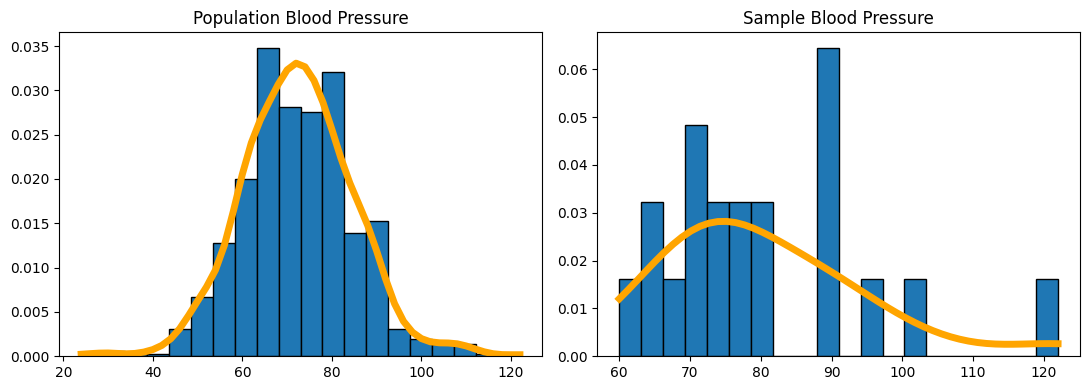

In [7]:
fig, axs = plt.subplots(1, 2, figsize=[11,4])

axs[0].hist(bp_all, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_all)
lin = np.linspace(bp_all.min(), bp_all.max(), 50)
axs[0].plot(lin, x(lin), color='orange', linewidth=5)
axs[0].set_title('Population Blood Pressure')

axs[1].hist(bp_sub, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_sub)
lin = np.linspace(bp_sub.min(), bp_sub.max(), 50)
axs[1].plot(lin, x(lin), color='orange', linewidth=5)
axs[1].set_title('Sample Blood Pressure')
        
fig.tight_layout()
plt.show()

The sample mean and sample standard deviation are both larger than the population mean and population standard deviation, respectively.

In [8]:
print('              Blood Pressure Population Mean: %.2f' % bp_all.mean())
print('Blood Pressure Population Standard Deviation: %.2f' % bp_all.std())
print('\n                  Blood Pressure Sample Mean: %.2f' % bp_sub.mean())
print('  Blood Pressure Population Sample Deviation: %.2f' % bp_sub.std())

              Blood Pressure Population Mean: 72.41
Blood Pressure Population Standard Deviation: 12.38

                  Blood Pressure Sample Mean: 80.55
  Blood Pressure Population Sample Deviation: 14.10


We now sample our posterior mean and standard deviation distributions using MCMC.

In [9]:
with pm.Model():
    mu = pm.Normal('mu', mu=70, sigma=5)
    sigma = pm.Lognormal('sigma', mu=2.5, sigma=0.44)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=bp_sub)
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


We see that the mode of our mean distribution is lower than the sample mean, getting closer to the population mean.

In [11]:
stacked = az.extract(trace)
kde = ss.gaussian_kde(stacked.mu.values)
lin = np.linspace(stacked.mu.values.min(), stacked.mu.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the mu distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the mu distribution is 77.47


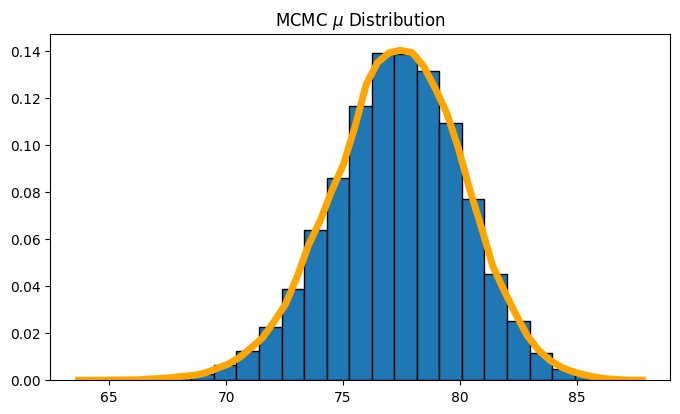

In [12]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\mu$ Distribution')
plt.show()

We see that the mode of our standard deviation distribution is lower than the standard deviation of our sample distribution, getting closer to the population standard deviation.

In [13]:
kde = ss.gaussian_kde(stacked.sigma.values)
lin = np.linspace(stacked.sigma.values.min(), stacked.sigma.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the sigma distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the sigma distribution is 13.92


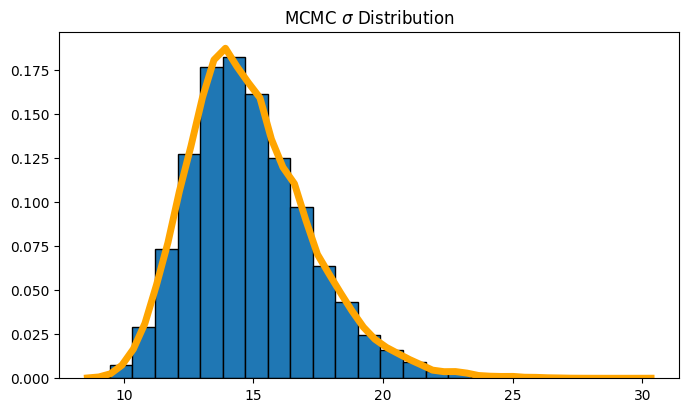

In [14]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\sigma$ Distribution')
plt.show()

Let's take another sample of our population, but this time with a sample mean that is much lower than our population mean.

In [29]:
np.random.seed(25)
bp_sub = np.random.choice(bp_all, size=20, replace=False, p=None)

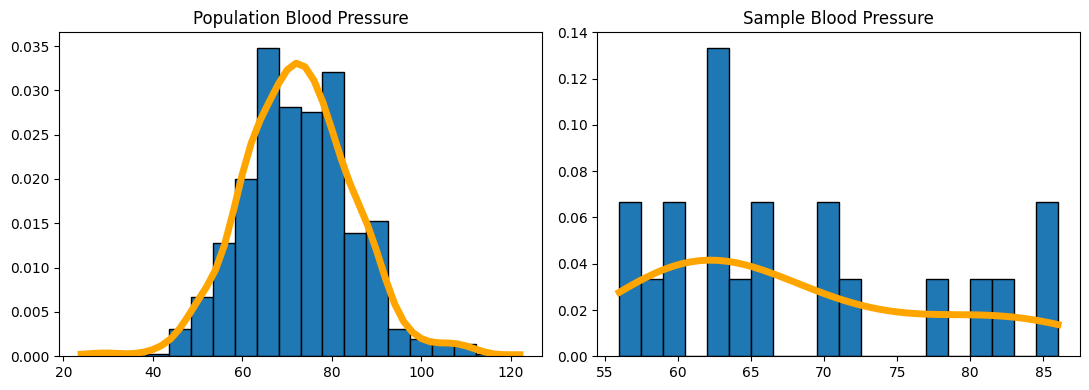

In [30]:
fig, axs = plt.subplots(1, 2, figsize=[11,4])

axs[0].hist(bp_all, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_all)
lin = np.linspace(bp_all.min(), bp_all.max(), 50)
axs[0].plot(lin, x(lin), color='orange', linewidth=5)
axs[0].set_title('Population Blood Pressure')

axs[1].hist(bp_sub, bins=20, edgecolor='black', density=True)
x = ss.gaussian_kde(bp_sub)
lin = np.linspace(bp_sub.min(), bp_sub.max(), 50)
axs[1].plot(lin, x(lin), color='orange', linewidth=5)
axs[1].set_title('Sample Blood Pressure')
        
fig.tight_layout()
plt.show()

The sample mean and sample standard deviation are both lower than than the population mean and population standard deviation, respectively.

In [31]:
print('              Blood Pressure Population Mean: %.2f' % bp_all.mean())
print('Blood Pressure Population Standard Deviation: %.2f' % bp_all.std())
print('\n                  Blood Pressure Sample Mean: %.2f' % bp_sub.mean())
print('  Blood Pressure Population Sample Deviation: %.2f' % bp_sub.std())

              Blood Pressure Population Mean: 72.41
Blood Pressure Population Standard Deviation: 12.38

                  Blood Pressure Sample Mean: 67.80
  Blood Pressure Population Sample Deviation: 9.39


In [38]:
with pm.Model():
    mu = pm.Normal('mu', mu=70, sigma=5)
    sigma = pm.Lognormal('sigma', mu=2.5, sigma=0.44)
    pmbp = pm.Normal('bp', mu=mu, sigma=sigma, observed=bp_sub)
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]


Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 3 seconds.


We see that the mode of our mean distribution is higher than the sample mean, getting closer to the population mean.

In [40]:
stacked = az.extract(trace)
kde = ss.gaussian_kde(stacked.mu.values)
lin = np.linspace(stacked.mu.values.min(), stacked.mu.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the mu distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the mu distribution is 68.55


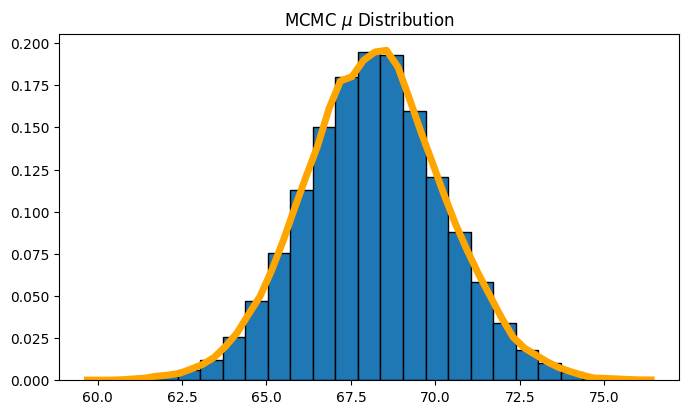

In [41]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.mu.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\mu$ Distribution')
plt.show()

We see that the mode of our standard deviation distribution is higher than the standard deviation of our sample distribution, getting closer to the population standard deviation.

In [42]:
kde = ss.gaussian_kde(stacked.sigma.values)
lin = np.linspace(stacked.sigma.values.min(), stacked.sigma.values.max(), 50)
kde_values = dict(zip(lin, kde(lin)))
print('The mode of the sigma distribution is %.2f' % max(kde_values, key=kde_values.get))

The mode of the sigma distribution is 9.74


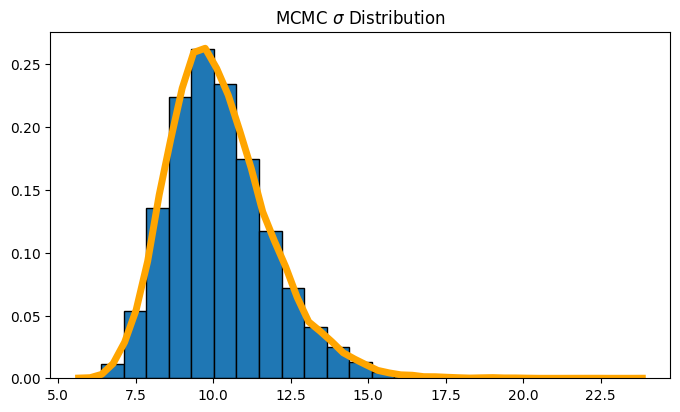

In [43]:
plt.figure(figsize=[8,4.5])
plt.hist(stacked.sigma.values, edgecolor='black', density=True, bins=25)
plt.plot(lin, kde(lin), color='orange', linewidth=5)
plt.title('MCMC $\sigma$ Distribution')
plt.show()

So, why is this important?